[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/baloghartur3/speaker-recognition/blob/main/Big_Homework.ipynb)

# Voice recognition

### Importing libraries

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
import math, random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D,Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from glob import glob
import soundfile
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras_tuner as kt
from tensorflow import keras

### Reding the .csv file that contains the name for each ID

In [6]:
#df.iloc[1]['relative_path'] this is how to index data!
#EVERY AUDIO HAS 1 CHANNEL
#EVEREY AUDIO HAS has a sampling rate of 16000

#The ''.csv' file needs to be in the working dir
data = pd.read_csv("vox1_meta.csv")

col_list = ["VoxCeleb1 ID", "VGGFace1 ID"]
data = pd.read_csv("vox1_meta.csv", usecols=col_list,sep='\t')
df = data.copy()
df['relative_path'] ='wav\\' + df['VoxCeleb1 ID'].astype(str) + '\\'
df['name'] = df['VGGFace1 ID']
df = df[['relative_path', 'name']]
df

,relative_path,name
0,wav\id10001\,A.J._Buckley
1,wav\id10002\,A.R._Rahman
2,wav\id10003\,Aamir_Khan
3,wav\id10004\,Aaron_Tveit
4,wav\id10005\,Aaron_Yoo
...,...,...
1246,wav\id11247\,Zachary_Levi
1247,wav\id11248\,Zachary_Quinto
1248,wav\id11249\,Zack_Snyder
1249,wav\id11250\,Zoe_Saldana


### Functions for audio file operations

In [7]:
# ----------------------------
# Load an audio file. Return the signal as an array and the sample rate
# ----------------------------
def audio_open(audio_file):
    sr, sig = wavfile.read(audio_file)
    #sig, sr = sf.read(audio_file)
    return (sig, sr)

# ----------------------------
# Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds and get multiple audio slices from aud (num_samples)
# ----------------------------
def pad_trunc(aud, num_samples, max_ms):
    sig, sr = aud
    sig_len = sig.shape[0]
    max_len = sr//1000 * max_ms
    sigs = []
    
    if (sig_len < sr+max_len):
        sig = np.concatenate((sig, sig))
        sig_len = sig.shape[0]
       
    #only in case of test and validation datasets
    if num_samples == 1:
        sigs = sig[sr:sr+max_len]
    #augmentation
    else:
        #calculate the step size
        contNum = int((sig_len-max_len)/(num_samples-1))
        for i in range(0, sig_len, contNum):
            if i == 0:
                sigs.append(sig[:max_len])
            elif len(sig[i:i+max_len])== sr*(max_ms/1000):
                sigs.append(sig[i:i+max_len])

    return (sigs, sr)

In [8]:
# ----------------------------
# For a given path, it iterates through its directories and subdirectories, searching for audio files
# ----------------------------
def iterate(path, wav_paths, classes, class_id):
    count=0
    rootdir = path #df.iloc[0]['relative_path']
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            wav_paths.append(os.path.join(subdir, file))
            classes.append(class_id)
            count+=1
    return count

### Data prepocessing

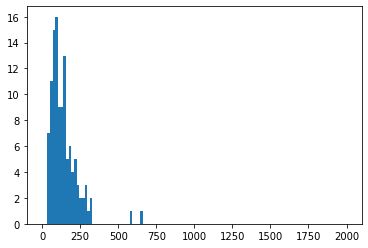

In [9]:
wav_paths = []
classes = []
counts=[]
new_class=[]
new_wav_path=[]
# number of person we want to work with (up to ~1200)
num_of_classes=50

#Storing the paths for every audio files
for i in range(num_of_classes):
    temp=iterate(df.iloc[i]['relative_path'],wav_paths, classes, i)
    counts.append(temp)
# List to array
classes = np.array(classes)
#making hystogram for visualizing the dataset
ls=[]
for i in counts:
    if i not in ls:
        ls.append(i)
plt.hist(ls, bins=len(ls), range=(0, 2000))

temp=-1
counter=10000

#Balancing the dataset
for i in range(len(wav_paths)):
    if temp!=classes[i]:
        if counter<(int)(np.average(counts)+30):
            start=i-counter
            end = i-1
            j=0
            while counter < (int)(np.average(counts)+30):
                new_wav_path.append(wav_paths[start+j])
                new_class.append(classes[start+j])
                j+=1
                if start+j+1 >end:
                    j=0
                counter += 1
        temp=classes[i]
        counter=0
    if counter<(int)(np.average(counts)+30):
        new_wav_path.append(wav_paths[i])
        new_class.append(classes[i])
        counter+=1
counter=0
temp=-1

In [10]:
# Separation of train, test and validation data
wav_train, wav_test, label_train, label_test = train_test_split(new_wav_path, new_class, test_size=0.1)
wav_train, wav_val, label_train, label_val = train_test_split(wav_train, label_train, test_size=0.22)

In [11]:
#the length of an audio data
dt = 2
# we process one audio file to get the input dimensions
aud = audio_open(wav_train[0])
aud, sr = pad_trunc(aud, 8, dt*1000)
#generating spectogram
freq, time, spec = signal.spectrogram(aud[0], sr)
spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
#getting the input dimension for the model
dim = spec.shape

### Setting up a model for hyperopt

In [47]:
def build_model(hp):
    filters1 = hp.Choice('filters1', [16, 32, 64, 128])
    filters2 = hp.Choice('filters2', [32, 64, 128])
    filters3 = hp.Choice('filters3', [64, 128, 256])
    
    model = Sequential()
    model.add(Conv2D(filters1, (3, 3), padding='same', input_shape=dim))
    model.add(Activation('relu'))
    model.add(Conv2D(filters2, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout1', min_value = 0, max_value=0.5, step=0.2)))
    model.add(Conv2D(filters2, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters2, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout2', min_value = 0, max_value=0.5, step=0.2)))
    model.add(Conv2D(filters3, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters3, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout3', min_value = 0, max_value=0.5, step=0.2)))
    model.add(Flatten())
    model.add(Dense(hp.Choice('units', [64, 128, 256, 512])))
    model.add(Activation('relu'))
    model.add(Dropout(hp.Float('dropout4', min_value = 0, max_value=0.5, step=0.2)))
    model.add(Dense(num_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Data generators

In [13]:
class TrainDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes, scaler, augmentation_size=4,
                 batch_size=32, shuffle=True):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.augmentation_size= augmentation_size
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor((len(self.wav_paths)*self.augmentation_size) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*(self.batch_size//self.augmentation_size):(index+1)*(self.batch_size//self.augmentation_size)]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]
        
        # generate a batch of time data
        X = np.empty((self.batch_size,dim[0],dim[1], 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
        
        p = 0
        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            aud = audio_open(path)
            aud, sr = pad_trunc(aud,self.augmentation_size, self.dt*1000)
            for k in range(self.augmentation_size):
                freq, time, spec = signal.spectrogram(aud[k], sr)
                spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
                X[p,] = spec
                Y[p,] = to_categorical(label, num_classes=self.n_classes)
                p += 1
       
        X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) 
        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [14]:
class ValDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes, scaler,
                 batch_size=1, shuffle=False):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = False
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor((len(self.wav_paths)) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*(self.batch_size):(index+1)*(self.batch_size)]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]
        
        # generate a batch of time data
        X = np.empty((self.batch_size, dim[0],dim[1], 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
        
        p = 0
        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            aud = audio_open(path)
            aud, sr = pad_trunc(aud, 1, dt*1000)
            freq, time, spec = signal.spectrogram(aud, sr)
            spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
            X[p,] = spec
            Y[p,] = to_categorical(label, num_classes=self.n_classes)
            p += 1
        
        X = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) #TODO csak a traint transform!
        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [15]:
#Standardization and generator init
scaler = preprocessing.StandardScaler()

tg = TrainDataGenerator(wav_train, label_train, sr, dt,
                       num_of_classes,augmentation_size=8, scaler=scaler, batch_size=32)
vg = ValDataGenerator(wav_val, label_val, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=32)
testg = ValDataGenerator(wav_test, label_test, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=1)

### Running keras-tuner with two algorithms

In [53]:
#Init tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    project_name='BO_project')

tuner.search(tg, epochs=10, validation_data=vg, callbacks=[keras.callbacks.TensorBoard("/tmp/BO_opt")],)
best_model_bo = tuner.get_best_models()[0]

#getting results
tuner.results_summary()

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs = 10,
    project_name='HB_project')
tuner.search(tg, epochs=10, validation_data=vg, callbacks=[keras.callbacks.TensorBoard("/tmp/HB_opt")],)
best_model_hb = tuner.get_best_models()[0]

#getting results
tuner.results_summary()

Trial 30 Complete [00h 11m 40s]
val_loss: 1.636130928993225

Best val_loss So Far: 1.166872262954712
Total elapsed time: 03h 33m 15s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\HB_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters1: 64
filters2: 128
filters3: 64
dropout1: 0.2
dropout2: 0.0
dropout3: 0.4
units: 512
dropout4: 0.4
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 1.166872262954712
Trial summary
Hyperparameters:
filters1: 64
filters2: 32
filters3: 64
dropout1: 0.2
dropout2: 0.0
dropout3: 0.4
units: 512
dropout4: 0.0
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 6ba1455faba4078dba49603f8256632e
Score: 1.634844183921814
Trial summary
Hyperparameters:
filters1: 32
filters2: 32
filters3: 128
dropout1: 0.0
dropout2: 0.0
dropout3: 0.2
units: 64
dropout4: 0.2
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/roun

#### Visualizing the optimization using TensorBoard

In [67]:
%load_ext tensorboard
%tensorboard --logdir /tmp/HB_opt
#%tensorboard --logdir /tmp/BO_opt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Further training of the best model

In [70]:
#The best model was find by the hyperband algorithm
best_model = best_model_hb

#Adding callback functions
callback = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='BestModel.hdf5', save_best_only=True, verbose=1)
#Model training
best_model.fit(tg, validation_data=vg,callbacks=[checkpoint, callback],
              epochs=50, verbose=1)

Epoch 1/50
1353/1353 [==============================] - 150s 111ms/step - loss: 0.6794 - accuracy: 0.7915 - val_loss: 1.1920 - val_accuracy: 0.6629

Epoch 00001: val_loss improved from inf to 1.19199, saving model to BestModel.hdf5
Epoch 2/50
1353/1353 [==============================] - 151s 112ms/step - loss: 0.5864 - accuracy: 0.8180 - val_loss: 1.2824 - val_accuracy: 0.6562

Epoch 00002: val_loss did not improve from 1.19199
Epoch 3/50
1353/1353 [==============================] - 152s 112ms/step - loss: 0.5714 - accuracy: 0.8246 - val_loss: 1.2790 - val_accuracy: 0.6855

Epoch 00003: val_loss did not improve from 1.19199
Epoch 4/50
1353/1353 [==============================] - 152s 113ms/step - loss: 0.5924 - accuracy: 0.8196 - val_loss: 1.1546 - val_accuracy: 0.6888

Epoch 00004: val_loss improved from 1.19199 to 1.15461, saving model to BestModel.hdf5
Epoch 5/50
1353/1353 [==============================] - 155s 114ms/step - loss: 0.5096 - accuracy: 0.8422 - val_loss: 1.3507 - val_a

### Testing and visualizing the results

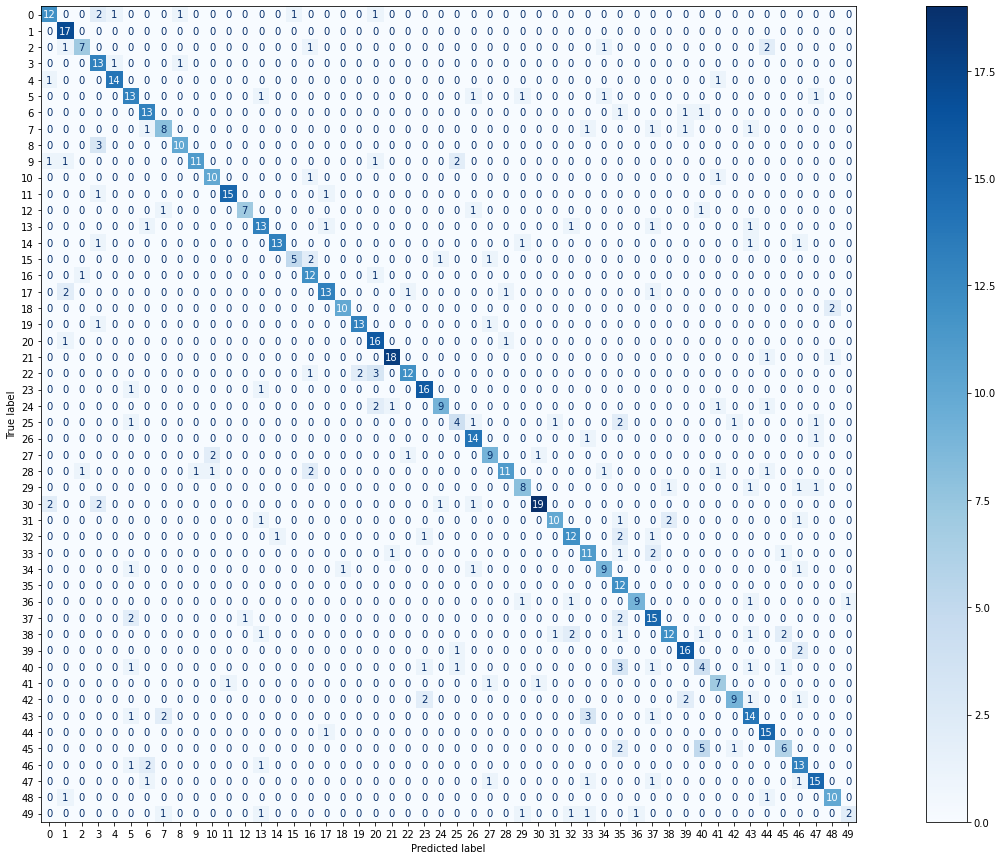

In [71]:
#Loading the best model
model = load_model('BestModel.hdf5')
#prediction
predictions = np.argmax(model.predict(testg), axis=-1)
#Visualization
c_matrix = confusion_matrix(label_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
plt.rcParams['figure.figsize'] = [25, 15]
disp.plot(cmap=plt.cm.Blues)
plt.show()
acc = accuracy_score(label_test, predictions)

In [72]:
#Output decoding
def label_to_name(label):
    return df.iloc[label]['name']

In [73]:
#Show a few results
for i in range(10):
    print("The actual person: " , label_to_name(label_test[i]))
    print("The predicted person: " , label_to_name(predictions[i]))
print("Accuracy: {:.2f}%".format((acc*100)))

The actual person:  Allison_Williams
The predicted person:  Allison_Williams
The actual person:  Amitabh_Bachchan
The predicted person:  Amitabh_Bachchan
The actual person:  Adam_Brody
The predicted person:  A.R._Rahman
The actual person:  Alison_Arngrim
The predicted person:  Alison_Arngrim
The actual person:  Abbie_Cornish
The predicted person:  Abbie_Cornish
The actual person:  Adam_Brody
The predicted person:  Adam_Brody
The actual person:  Alison_Pill
The predicted person:  Alison_Pill
The actual person:  Alba_Rohrwacher
The predicted person:  Alba_Rohrwacher
The actual person:  Aaron_Tveit
The predicted person:  Aaron_Tveit
The actual person:  America_Ferrera
The predicted person:  America_Ferrera
Accuracy: 73.32%


In [74]:
#The parameters of the final model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 129, 142, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 129, 142, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 140, 128)     73856     
_________________________________________________________________
activation_1 (Activation)    (None, 127, 140, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 70, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 70, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 70, 128)       1

### Building new models with different input parameters

#### num_of_classes = 200

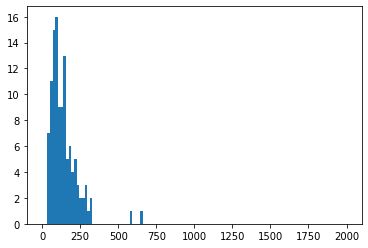

In [24]:
wav_paths = []
classes = []
counts=[]
new_class=[]
new_wav_path=[]
# number of person we want to work with (up to ~1200)
num_of_classes=200

#Storing the paths for every audio files
for i in range(num_of_classes):
    temp=iterate(df.iloc[i]['relative_path'],wav_paths, classes, i)
    counts.append(temp)
# List to array
classes = np.array(classes)
#making hystogram for visualizing the dataset
ls=[]
for i in counts:
    if i not in ls:
        ls.append(i)
plt.hist(ls, bins=len(ls), range=(0, 2000))

temp=-1
counter=10000

#Balancing the dataset
for i in range(len(wav_paths)):
    if temp!=classes[i]:
        if counter<(int)(np.average(counts)+30):
            start=i-counter
            end = i-1
            j=0
            while counter < (int)(np.average(counts)+30):
                new_wav_path.append(wav_paths[start+j])
                new_class.append(classes[start+j])
                j+=1
                if start+j+1 >end:
                    j=0
                counter += 1
        temp=classes[i]
        counter=0
    if counter<(int)(np.average(counts)+30):
        new_wav_path.append(wav_paths[i])
        new_class.append(classes[i])
        counter+=1
counter=0
temp=-1

In [25]:
# Separation of train, test and validation data
wav_train, wav_test, label_train, label_test = train_test_split(new_wav_path, new_class, test_size=0.1)
wav_train, wav_val, label_train, label_val = train_test_split(wav_train, label_train, test_size=0.22)

In [26]:
#the length of an audio data
dt = 2
# we process one audio file to get the input dimensions
aud = audio_open(wav_train[0])
aud, sr = pad_trunc(aud, 8, dt*1000)
#generating spectogram
freq, time, spec = signal.spectrogram(aud[0], sr)
spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
#getting the input dimension for the model
dim = spec.shape

#### The model is based on the best model of the optimizers

In [27]:
def model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=dim))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [28]:
tuned_model = model()

#Adding callback functions
callback = EarlyStopping(monitor='val_loss', patience=15)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='BestModel.hdf5', save_best_only=True, verbose=1)
#Model training
tuned_model.fit(tg, validation_data=vg,callbacks=[checkpoint, callback],
              epochs=300, verbose=1)

Epoch 1/300
5229/5229 [==============================] - 1053s 201ms/step - loss: 5.3020 - accuracy: 0.0041 - val_loss: 5.3019 - val_accuracy: 0.0049

Epoch 00001: val_loss improved from inf to 5.30187, saving model to BestModel.hdf5
Epoch 2/300
5229/5229 [==============================] - 1044s 200ms/step - loss: 5.3003 - accuracy: 0.0044 - val_loss: 5.3039 - val_accuracy: 0.0032

Epoch 00002: val_loss did not improve from 5.30187
Epoch 3/300
5229/5229 [==============================] - 1044s 200ms/step - loss: 5.3002 - accuracy: 0.0045 - val_loss: 5.3051 - val_accuracy: 0.0032

Epoch 00003: val_loss did not improve from 5.30187
Epoch 4/300
5229/5229 [==============================] - 1060s 203ms/step - loss: 5.3001 - accuracy: 0.0044 - val_loss: 5.3055 - val_accuracy: 0.0041

Epoch 00004: val_loss did not improve from 5.30187
Epoch 5/300
5229/5229 [==============================] - 1043s 199ms/step - loss: 5.3001 - accuracy: 0.0046 - val_loss: 5.3057 - val_accuracy: 0.0027

Epoch 000

#### We can see a very low val_accuracy

#### Testing with low audio length (1s)

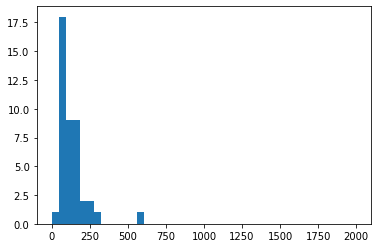

In [32]:
wav_paths = []
classes = []
counts=[]
new_class=[]
new_wav_path=[]
# number of person we want to work with (up to ~1200)
num_of_classes=50

#Storing the paths for every audio files
for i in range(num_of_classes):
    temp=iterate(df.iloc[i]['relative_path'],wav_paths, classes, i)
    counts.append(temp)
# List to array
classes = np.array(classes)
#making hystogram for visualizing the dataset
ls=[]
for i in counts:
    if i not in ls:
        ls.append(i)
plt.hist(ls, bins=len(ls), range=(0, 2000))

temp=-1
counter=10000

#Balancing the dataset
for i in range(len(wav_paths)):
    if temp!=classes[i]:
        if counter<(int)(np.average(counts)+30):
            start=i-counter
            end = i-1
            j=0
            while counter < (int)(np.average(counts)+30):
                new_wav_path.append(wav_paths[start+j])
                new_class.append(classes[start+j])
                j+=1
                if start+j+1 >end:
                    j=0
                counter += 1
        temp=classes[i]
        counter=0
    if counter<(int)(np.average(counts)+30):
        new_wav_path.append(wav_paths[i])
        new_class.append(classes[i])
        counter+=1
counter=0
temp=-1

In [33]:
# Separation of train, test and validation data
wav_train, wav_test, label_train, label_test = train_test_split(new_wav_path, new_class, test_size=0.1)
wav_train, wav_val, label_train, label_val = train_test_split(wav_train, label_train, test_size=0.22)

In [34]:
#the length of an audio data
dt = 1
# we process one audio file to get the input dimensions
aud = audio_open(wav_train[0])
aud, sr = pad_trunc(aud, 8, dt*1000)
#generating spectogram
freq, time, spec = signal.spectrogram(aud[0], sr)
spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
#getting the input dimension for the model
dim = spec.shape

In [35]:
def model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=dim))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
#Standardization and generator init
scaler = preprocessing.StandardScaler()

tg = TrainDataGenerator(wav_train, label_train, sr, dt,
                       num_of_classes,augmentation_size=8, scaler=scaler, batch_size=32)
vg = ValDataGenerator(wav_val, label_val, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=32)
testg = ValDataGenerator(wav_test, label_test, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=1)

In [38]:
tuned_model = model()

#Adding callback functions
callback = EarlyStopping(monitor='val_loss', patience=15)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='BestModel.hdf5', save_best_only=True, verbose=1)
#Model training
tuned_model.fit(tg, validation_data=vg,callbacks=[checkpoint, callback],
              epochs=300, verbose=1)

Epoch 1/300
1353/1353 [==============================] - 123s 89ms/step - loss: 3.9141 - accuracy: 0.0184 - val_loss: 3.9117 - val_accuracy: 0.0120

Epoch 00001: val_loss improved from inf to 3.91166, saving model to BestModel.hdf5
Epoch 2/300
1353/1353 [==============================] - 120s 89ms/step - loss: 3.9110 - accuracy: 0.0188 - val_loss: 3.9119 - val_accuracy: 0.0126

Epoch 00002: val_loss did not improve from 3.91166
Epoch 3/300
1353/1353 [==============================] - 120s 89ms/step - loss: 3.9123 - accuracy: 0.0221 - val_loss: 3.9118 - val_accuracy: 0.0126

Epoch 00003: val_loss did not improve from 3.91166
Epoch 4/300
1353/1353 [==============================] - 120s 89ms/step - loss: 3.9097 - accuracy: 0.0206 - val_loss: 3.9121 - val_accuracy: 0.0126

Epoch 00004: val_loss did not improve from 3.91166
Epoch 5/300
1353/1353 [==============================] - 120s 89ms/step - loss: 3.9093 - accuracy: 0.0228 - val_loss: 3.9125 - val_accuracy: 0.0126

Epoch 00005: val_lo

#### Here, the val_accuracy was also very low